In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
import os 
os.chdir("/content/gdrive/My Drive/BertTweet")

Mounted at /content/gdrive


In [ ]:
!pip install -q transformers==2.1.1
!pip install -q torch

     |████████████████████████████████| 317kB 10.0MB/s 
     |████████████████████████████████| 901kB 19.6MB/s 
     |████████████████████████████████| 1.2MB 36.3MB/s 
     |████████████████████████████████| 133kB 54.1MB/s 
     |████████████████████████████████| 81kB 13.0MB/s 
     |████████████████████████████████| 7.5MB 57.3MB/s 
ERROR: botocore 1.20.67 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.


In [ ]:
import numpy as np 
import pandas as pd 
from pathlib import Path 

import os

import torch
import torch.optim as optim

import random 

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig
#from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig


In [ ]:
#MODEL_CLASSES = {'bert': (BertForSequenceClassification, BertTokenizer, BertConfig)}
MODEL_CLASSES = {'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig)}

In [ ]:
# Parameters
seed = 42
use_fp16 = False
bs = 16

model_type = 'roberta'
#pretrained_model_name = 'bert-base'
pretrained_model_name = 'roberta-base'


In [ ]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [ ]:
def seed_all(seed_value):
    random.seed(seed_value) 
    np.random.seed(seed_value) 
    torch.manual_seed(seed_value) 
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True  
        torch.backends.cudnn.benchmark = False
seed_all(seed)

In [ ]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'roberta', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['bert']:  #if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] +  [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens

In [ ]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In [ ]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

In [ ]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

In [ ]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [ ]:
train = pd.read_csv('data_train.csv')
test = pd.read_csv('data_test.csv')


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27564 entries, 0 to 27563
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  27564 non-null  object
 1   Tweets  27564 non-null  object
dtypes: object(2)
memory usage: 430.8+ KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6891 entries, 0 to 6890
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  6891 non-null   object
 1   Tweets  6891 non-null   object
dtypes: object(2)
memory usage: 107.8+ KB


In [ ]:
databunch = (TextList.from_df(train, cols='Tweets', processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols= 'target')
             .add_test(test)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)
databunch.show_batch()

[CLS] token : <s>
[SEP] token : </s>
[PAD] token : <pad>


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  idx_min = (t != self.pad_idx).nonzero().min()


text,target
<s> Ġbat man Ġmay Ġof Ġbeen Ġthe Ġbetter Ġman Ġin Ġour Ġlast Ġencounter Ġbut Ġi 'm Ġa Ġman Ġon Ġa Ġmission Ġand Ġit 's Ġto Ġexpose Ġyou Ġfor Ġwhat Ġyou Ġreally Ġare Ġand Ġ6 407 1080 550 8 49 74 15 Ġpositive Ġhe ath Ġledger Ġin Ġbat man Ġmay Ġbe Ġthe Ġbest Ġperformance Ġof Ġany Ġactor Ġin Ġany Ġmovie Ġof Ġall Ġtime Ġ640 71 196 125 299 09 76 Ġneutral,positive
<s> Ġuber Ġand Ġg aut rain Ġhow Ġdo Ġi Ġthank Ġthee Ġ Ġcl apping _ hands _ medium _ skin _ tone Ġ Ġraising _ hands _ medium _ skin _ tone Ġ Ġgrinning _ face _ with _ sm iling _ eyes Ġ Ġloudly _ c rying _ face Ġ Ġloudly _ c rying _ face Ġ Ġgrinning _ face Ġ Ġparty _ po pper </s>,positive
<s> Ġat Ġtimes now Ġhow Ġmuch Ġr Ġu Ġpaid Ġ2 Ġexclude Ġox ford Ġdon \ u 002 c Ġkh ur sh id Ġas Ġ1 Ġof Ġd Ġi ac Ġexpose Ġhope Ġtoday Ġwill Ġbe Ġthe Ġ4 th Ġafter Ġv adra \ u 002 c Ġkh ur sh id \ u 002 c Ġgad k ari </s>,neutral
<s> Ġbuy Ġ1 Ġget Ġ1 Ġfree Ġt ik et Ġthe Ġgreatest Ġhits Ġtour Ġblue \ u 002 c Ġa 1 \ u 002 c Ġ& Ġje ff Ġtim mons Ġ98 Ġdegrees Ġonly Ġfor Ġto mm or ow Ġ19 Ġfe b Ġpur i Ġmall Ġ& Ġpond ok Ġind ah Ġmall Ġ1 </s>,positive
<s> Ġi Ġwanna Ġwish Ġat Ġj ay l aura Ġa Ġhappy Ġ21 st Ġb day Ġshe \ u 2019 s Ġan Ġamazing Ġgal \ u 002 c Ġwe \ u 2019 ve Ġonly Ġhung Ġout Ġonce Ġbut Ġshe Ġis Ġone Ġof Ġa Ġkind Ġenjoy Ġit Ġr iri Ġ) </s>,positive


In [ ]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        # attention_mask
        # Mask to avoid performing attention on padding token indices.
        # Mask values selected in ``[0, 1]``:
        # ``1`` for tokens that are NOT MASKED, ``0`` for MASKED tokens.
        attention_mask = (input_ids!=pad_idx).type(input_ids.type()) 
        
        logits = self.transformer(input_ids,
                                  attention_mask = attention_mask)[0]   
        return logits

In [ ]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 3
config.use_bfloat16 = use_fp16
print(config)

100%|██████████| 481/481 [00:00<00:00, 233691.67B/s]

{
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 3,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pad_token_id": 1,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 1,
  "use_bfloat16": false,
  "vocab_size": 50265
}



In [ ]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

100%|██████████| 501200538/501200538 [00:07<00:00, 63400115.31B/s]


In [ ]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy, error_rate])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

if use_fp16: learner = learner.to_fp16()


In [ ]:
# For roberta-base
list_layers = [learner.model.transformer.roberta.embeddings,
              learner.model.transformer.roberta.encoder.layer[0],
              learner.model.transformer.roberta.encoder.layer[1],
              learner.model.transformer.roberta.encoder.layer[2],
              learner.model.transformer.roberta.encoder.layer[3],
              learner.model.transformer.roberta.encoder.layer[4],
              learner.model.transformer.roberta.encoder.layer[5],
              learner.model.transformer.roberta.encoder.layer[6],
              learner.model.transformer.roberta.encoder.layer[7],
              learner.model.transformer.roberta.encoder.layer[8],
              learner.model.transformer.roberta.encoder.layer[9],
              learner.model.transformer.roberta.encoder.layer[10],
              learner.model.transformer.roberta.encoder.layer[11],
              learner.model.transformer.roberta.pooler]

In [ ]:
learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
print(learner.layer_groups)

In [ ]:
learner.save('untrain')

In [ ]:
seed_all(seed)
learner.load('untrain')

In [ ]:
learner.freeze_to(-1)

In [ ]:
learner.summary()

In [ ]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.91E-06
Min loss divided by 10: 6.31E-08


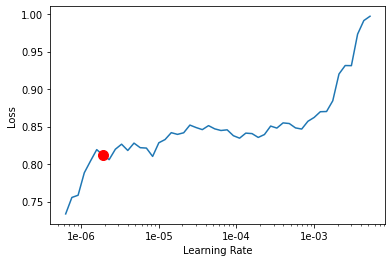

In [ ]:
learner.recorder.plot(skip_end=10,suggestion=True)

In [ ]:
min_grad_lr = learner.recorder.min_grad_lr
min_grad_lr

1.096478196143185e-06

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.571030,0.703496,0.696662,0.303338,01:09
1,0.540687,0.704000,0.697388,0.302612,01:09
2,0.496312,0.704180,0.697025,0.302975,01:09


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


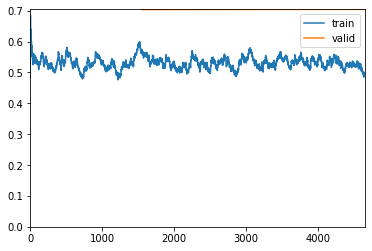

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [ ]:
learner.fit_one_cycle(3,min_grad_lr,moms=(0.8,0.7))

In [ ]:
learner.save('first_cycle')

In [ ]:
seed_all(seed)
learner.load('first_cycle')

In [ ]:
learner.freeze_to(-2)

In [ ]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07
Min loss divided by 10: 7.59E-08


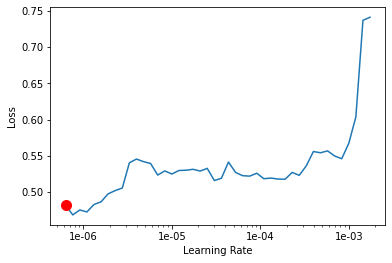

In [ ]:
learner.recorder.plot(skip_end=10,suggestion=True)

In [ ]:
min_grad_lr_2 = learner.recorder.min_grad_lr
min_grad_lr_2

In [ ]:
lr = min_grad_lr_2
learner.fit_one_cycle(3, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [ ]:
learner.save('second_cycle')

In [ ]:
seed_all(seed)
learner.load('second_cycle');

In [ ]:
learner.freeze_to(-3)

In [ ]:
learner.recorder.plot(skip_end=10,suggestion=True)

In [ ]:
min_grad_lr_3 = learner.recorder.min_grad_lr
min_grad_lr_3

0.00019931187523568038

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.715123,0.685637,0.692671,0.307329,01:26
1,0.688130,0.655894,0.706459,0.293541,01:25
2,0.579421,0.670176,0.703193,0.296807,01:29


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


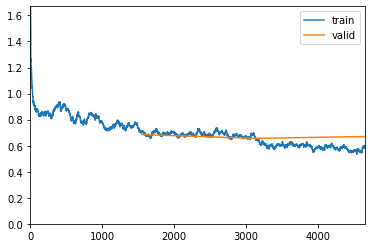

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [ ]:
learner.fit_one_cycle(3, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [ ]:
learner.save('third_cycle')

In [ ]:
seed_all(seed)
learner.load('third_cycle')

In [ ]:
learner.export(file = 'roberta.pt');

In [ ]:
learner = load_learner("", 'roberta.pt')

In [ ]:
learner.predict('I hate you corona')

(Category tensor(0), tensor(0), tensor([0.9950, 0.0039, 0.0011]))

In [ ]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = learner.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in databunch.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    return preds[reverse_sampler, :]

#test_preds = get_preds_as_nparray(DatasetType.Test)

In [ ]:
test_preds = get_preds_as_nparray(DatasetType.Test)

In [ ]:
def sentiment_label (Sentiment):
   if Sentiment == 2:
       return "positive"
   elif Sentiment ==0 :
       return "negative"
   else:
       return  "neutral"

def predict_sentiment(text):
  sentiment = learner.predict(text)[1].item()
  return sentiment

In [ ]:
def convert_label (Sentiment):
   if Sentiment == "positive":
       return 2
   elif Sentiment =="negative" :
       return 0
   else:
       return  1

In [ ]:
test = pd.concat([neg,pos,neu])
test['Label'].value_counts()

neutral     100
negative    100
positive    100
Name: Label, dtype: int64

In [ ]:
test["pred"]=test["Tweets"].apply(predict_sentiment).apply(sentiment_label)

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

In [ ]:
class_names = ['negative','positive','neutral']
print(classification_report(test['Label'], test['pred'], target_names=class_names))

              precision    recall  f1-score   support

    negative       0.79      0.31      0.45       100
    positive       0.63      0.97      0.77       100
     neutral       0.65      0.70      0.67       100

    accuracy                           0.66       300
   macro avg       0.69      0.66      0.63       300
weighted avg       0.69      0.66      0.63       300



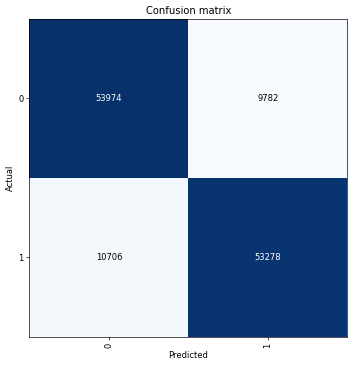

In [ ]:
interp = ClassificationInterpretation.from_learner(learner) 
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

## **Vaccine Prediction**

In [ ]:
import glob
path = "hashtag/*.csv"
csv_list = glob.glob(path) # collecting all files  same path 
print(len(csv_list))
print(csv_list)

4
['hashtag/chinese_vac.csv', 'hashtag/oxford_vac.csv', 'hashtag/pfizer_vac.csv', 'hashtag/moderna_vac.csv']


In [ ]:
d_ox = pd.read_csv('predicted/oxford_vac.csv')
d_ox.target.value_counts()

positive    456
neutral     333
negative    150
Name: target, dtype: int64

In [ ]:
df_tweet.target.value_counts()

positive    412
neutral     319
negative    150
Name: target, dtype: int64

In [ ]:
d_pf = pd.read_csv('predicted/oxford_vac.csv')
d_pf.target.value_counts()

positive    584
neutral     274
negative    120
Name: target, dtype: int64

In [ ]:
for f in csv_list:
  d = pd.read_csv(f)
  for i,row in df_tweet.iterrows():
    d['Tweets'][i] = clean_hashtag(d['Tweets'][i])
    d['Tweets'][i] = clean_html(d['Tweets'][i])
    d['Tweets'][i] = clean_punc(d['Tweets'][i])
    d['Tweets'][i] = replace_emoji(d['Tweets'][i])
    d['Tweets'][i] = replace_at(d['Tweets'][i])
  d['Tweets']=d["Tweets"].drop_duplicates()
  d = d.dropna(axis=0,how='any')
  d = d.reset_index(drop=True)
  d['target'] = d['Tweets'].apply(predict_sentiment).apply(sentiment_label)
  d.to_csv('predicted'+f[7:])
  

